In [1]:
import os
import torch
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.autolayout': True})

from data.toy_data.hyperbolic import hyperbolic
from data.toy_data.circle import circle

from src.diffeomorphisms.vanilla_hyperboloid import Vanilla_into_Hyperboloid
from src.diffeomorphisms.vanilla_sphere import Vanilla_into_Sphere
from src.manifolds.pull_back_manifold import PullBackManifold
from src.riemannian_autoencoder import Curvature_Corrected_Riemannian_Autoencoder
from src.riemannian_autoencoder.low_rank_approximation.naive_tsvd import naive_low_rank_approximation

# set seed
torch.manual_seed(31)

results_path = os.path.join("results")

In [2]:
# data parameters
num_data = 21
noise = 0.02

# plot options
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

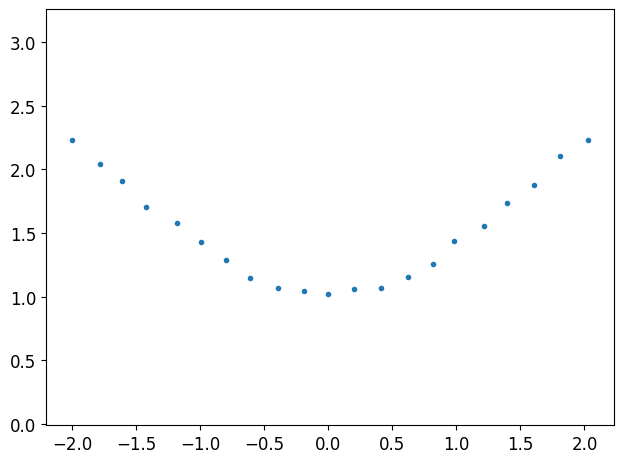

In [3]:
# Construct data
h_data = hyperbolic(num_data, noise=noise)
h_data_manifold = hyperbolic(250, noise=0.)

plt.plot(h_data[:,0], h_data[:,1], '.')
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"h_data.eps"))
plt.show()

In [4]:
# construct hyperbolic pullback manifold
h_offset = torch.zeros((2,))
h_orthogonal = torch.eye(2,2)
h_diffeo = Vanilla_into_Hyperboloid(2, h_offset, h_orthogonal)

h_M = PullBackManifold(h_diffeo)

In [5]:
# choose special points
h_z1 = h_data[0][None]
h_z2 = h_data[-1][None]
h_z3 = torch.tensor([0., 1.])[None]

In [6]:
# geodesic interpolation
h_data_gamma_12_t = hyperbolic(250, noise=0.)
h_adjacent_distances = torch.norm(h_data_gamma_12_t[1:] - h_data_gamma_12_t[:-1], 2, -1)
h_cumulative_distances = torch.cat((torch.zeros(1), torch.cumsum(h_adjacent_distances, 0)),0)
h_t = h_cumulative_distances / h_cumulative_distances[-1]

h_z1_var = h_z1 + 0.25 * torch.tensor([1.,0.])

h_gamma_12_t =  h_M.geodesic(h_z1, h_z2, h_t)

# compute error
error_h_gamma_12_t = torch.norm(h_gamma_12_t - h_data_gamma_12_t, 2, -1)

# compute geodesics variation
h_gamma_12_var_t =  h_M.geodesic(h_z1_var, h_z2, h_t)

# compute error wrt original geodesic
error_h_gamma_12_var_t = torch.norm(h_gamma_12_var_t - h_gamma_12_t, 2, -1) 

/Users/wdiepeveen/Documents/PhD/Projects/10 - Learning Riemannian Geometry/src/article/Pulling-back-symmetric-Riemannian-geometry-for-data-analysis/src/diffeomorphisms/simple_diffeomorphisms/stereographic_hyperboloid.py:30: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  output[-1] = torch.sqrt(s_sq.T + 1)


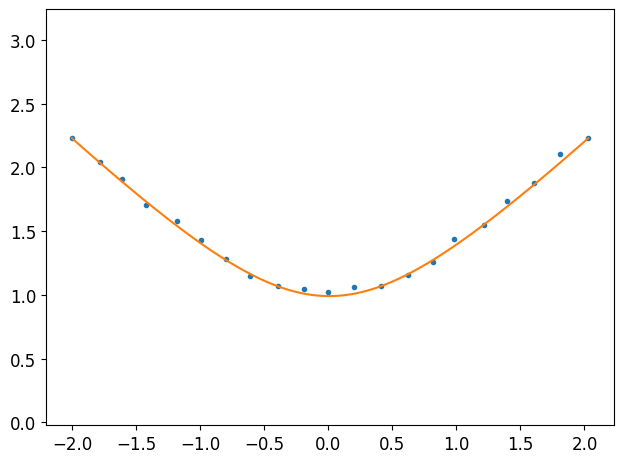

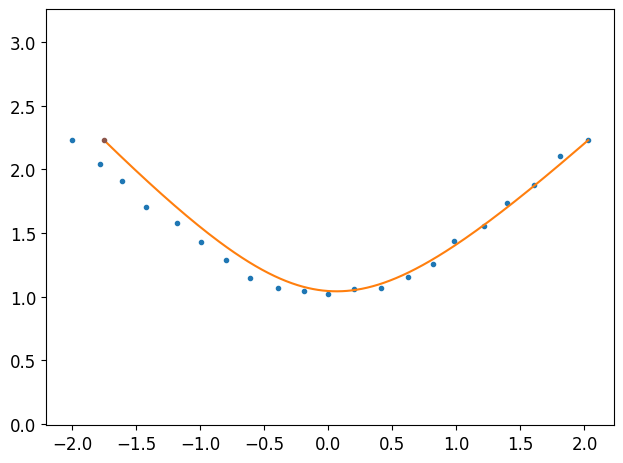

average error = 0.23148012161254883 \pm 0.11272000521421432
average variation error = 0.09133171290159225 \pm 0.053054485470056534


In [7]:
# plot geodesics
plt.plot(h_data[:,0], h_data[:,1], '.')
plt.plot(h_gamma_12_t.squeeze().detach().numpy()[:,0], h_gamma_12_t.squeeze().detach().numpy()[:,1])
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"geodesics_on_h_M.eps"))
plt.show()

# plot geodesic variations
plt.plot(h_data[:,0], h_data[:,1], '.')
plt.plot(h_gamma_12_var_t.squeeze().detach().numpy()[:,0], h_gamma_12_var_t.squeeze().detach().numpy()[:,1])
plt.plot(h_z1_var[:,0], h_z1_var[:,1], '.', color=colors[5])
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"geodesic_variations_on_h_M.eps"))
plt.show()

# print errors
h_mean_error = torch.mean(error_h_gamma_12_t)
h_std_error = torch.std(error_h_gamma_12_t)
print(f"average error = {h_mean_error.squeeze().detach().numpy()} \pm {h_std_error.squeeze().detach().numpy()}")

h_mean_var_error = torch.mean(error_h_gamma_12_var_t)
h_std_var_error = torch.std(error_h_gamma_12_var_t)
print(f"average variation error = {h_mean_var_error.squeeze().detach().numpy()} \pm {h_std_var_error.squeeze().detach().numpy()}")

In [8]:
# barycentre
h_data_var = h_data + 0.05 * torch.randn((num_data, 2))

# compute barycentre
h_barycentre = h_M.barycentre(h_data[None])

# compute error
error_h_barycentre = torch.norm(h_barycentre - torch.tensor([0., 1.]), 2, -1)

# compute geodesics variation
h_barycentre_var =  h_M.barycentre(h_data_var[None])

# compute error wrt original geodesic
error_h_barycentre_var = torch.norm(h_barycentre_var - h_barycentre, 2, -1)

gradient descent was terminated after reaching a relative error 0.0009658673079684377 in 3 iterations
gradient descent was terminated after reaching a relative error 0.0009423954179510474 in 2 iterations


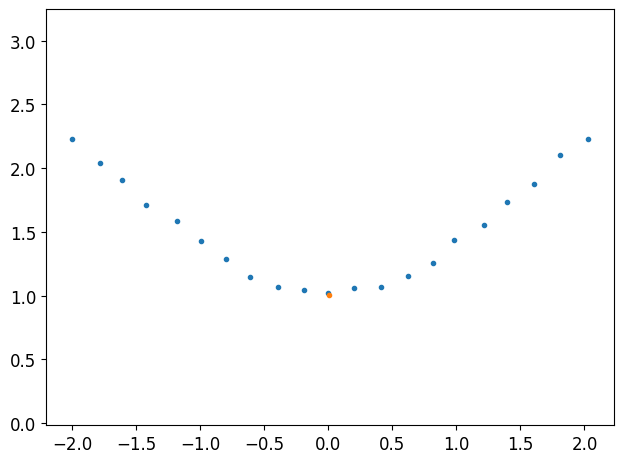

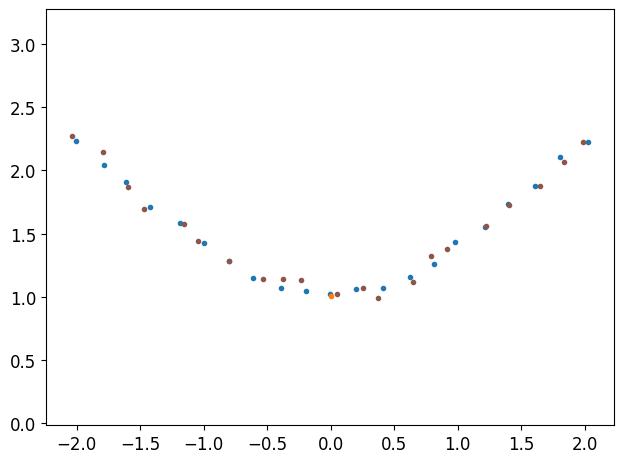

error = 0.002922444138675928
average variation error = 0.003849267726764083


In [9]:
# plot barycentre
plt.plot(h_data[:,0], h_data[:,1], '.')
plt.plot(h_barycentre[:,0].detach().numpy(), h_barycentre[:,1].detach().numpy(), '.')
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"barycentre_on_h_M.eps"))
plt.show()

plt.plot(h_data[:,0], h_data[:,1], '.')
plt.plot(h_barycentre_var[:,0].detach().numpy(), h_barycentre_var[:,1].detach().numpy(), '.')
plt.plot(h_data_var[:,0], h_data_var[:,1], '.', color=colors[5])
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"barycentre_variation_on_h_M.eps"))
plt.show()

# print errors
print(f"error = {(error_h_barycentre).squeeze().detach().numpy()}")

print(f"average variation error = {(error_h_barycentre_var).squeeze().detach().numpy()}")

In [10]:
# compute logs
h_logs = h_M.log(h_z3, h_data[None])[0]

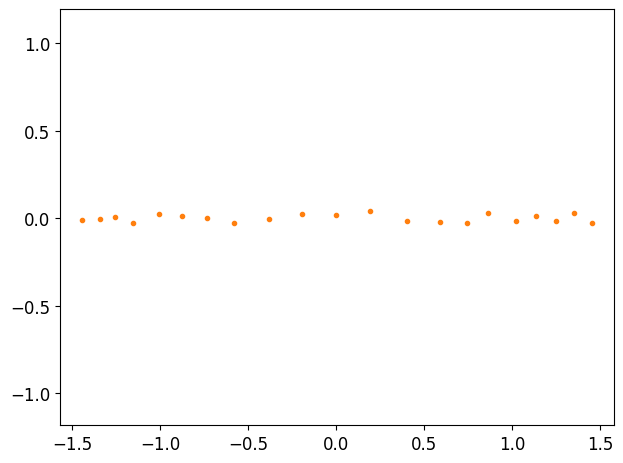

In [11]:
plt.plot(h_logs.squeeze().detach().numpy()[:,0], h_logs.squeeze().detach().numpy()[:,1], '.', color=colors[1])
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"logs_on_h_M.eps"))
plt.show()

In [12]:
# low rank approximation
noisy_h_data = hyperbolic(250, noise=0.25)

h_z = h_z3

# construct CC-RAE from test data

# i) rank 1 approximation
h_R_z, h_U = naive_low_rank_approximation(h_M, h_z, h_data, 1)
h_w_z = h_R_z / h_M.norm(h_z, h_R_z[None])[:,None]

# ii) construct CC-RAE
h_rae_w_z = Curvature_Corrected_Riemannian_Autoencoder(h_M, h_z, h_w_z)

# project noisy validation data onto manifold with RAE
projected_h_mesh = h_rae_w_z.project_on_manifold(h_data)

# compute error
error_projected_h_mesh = torch.norm(projected_h_mesh - h_data, 2, -1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


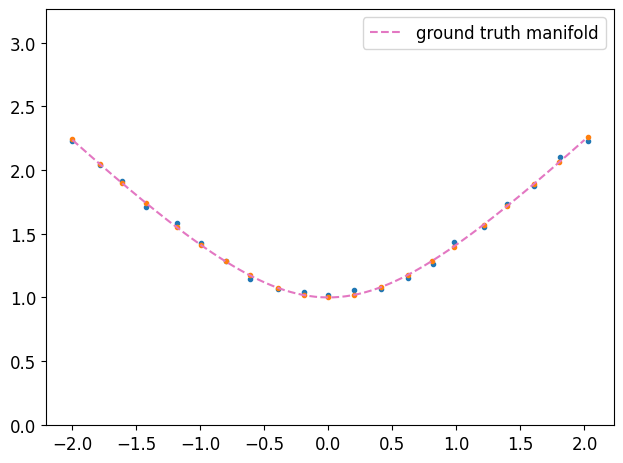

average error = 0.021841682493686676 \pm 0.011618481017649174


In [13]:
# plot rae projections
plt.plot(h_data[:,0], h_data[:,1], '.')
plt.plot(projected_h_mesh.cpu().detach().numpy()[:,0], projected_h_mesh.cpu().detach().numpy()[:,1], '.')
plt.plot(h_data_manifold[:,0], h_data_manifold[:,1], "--", label="ground truth manifold", color=colors[6])
plt.legend()
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"rae_projections_on_h_M.eps"))
plt.show()

# print errors
mean_h_rae_error = torch.mean(error_projected_h_mesh)
std_h_rae_error = torch.std(error_projected_h_mesh)
print(f"average error = {mean_h_rae_error.squeeze().detach().numpy()} \pm {std_h_rae_error.squeeze().detach().numpy()}")

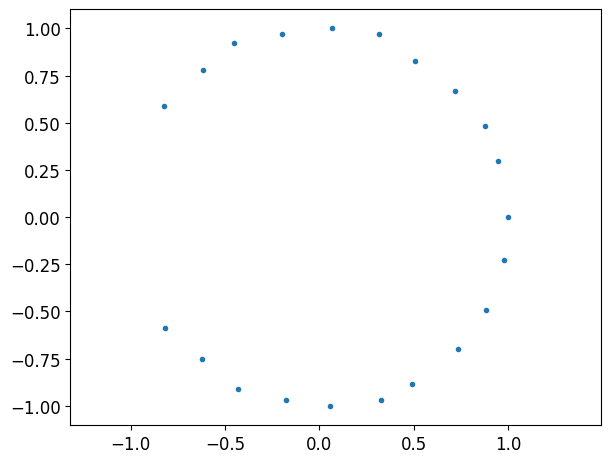

In [14]:
c_data = circle(num_data, noise=noise)
c_data_manifold = circle(250, noise=0.)

plt.plot(c_data[:,0], c_data[:,1], '.')
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"c_data.eps"))
plt.show()

In [15]:
# construct spherical pullback manifold
c_offset = torch.zeros((2,))
c_orthogonal = torch.eye(2,2)
c_diffeo = Vanilla_into_Sphere(2, c_offset, c_orthogonal)

c_M = PullBackManifold(c_diffeo)

In [16]:
# choose special points
c_z1 = c_data[0][None]
c_z2 = c_data[int(4*num_data/7)][None]
c_z3 = c_data[int(num_data/2)][None]
c_z4 = torch.tensor([1., 0.])[None]

In [17]:
# geodesic interpolation
c_data_gamma_12_t = circle(250, noise=0.)
c_adjacent_distances = torch.norm(c_data_gamma_12_t[1:] - c_data_gamma_12_t[:-1], 2, -1)
c_cumulative_distances = torch.cat((torch.zeros(1), torch.cumsum(c_adjacent_distances, 0)),0)
c_t = c_cumulative_distances / c_cumulative_distances[-1]

c_z1_var = c_z1 + 0.25 * torch.tensor([1.,0.])

c_gamma_12_t =  c_M.geodesic(c_z1, c_z2, c_t)

# compute error
error_c_gamma_12_t = torch.norm(c_gamma_12_t - c_data_gamma_12_t, 2, -1)

# compute geodesics variation
c_gamma_12_var_t =  c_M.geodesic(c_z1_var, c_z2, c_t)

# compute error wrt original geodesic
error_c_gamma_12_var_t = torch.norm(c_gamma_12_var_t - c_gamma_12_t, 2, -1)

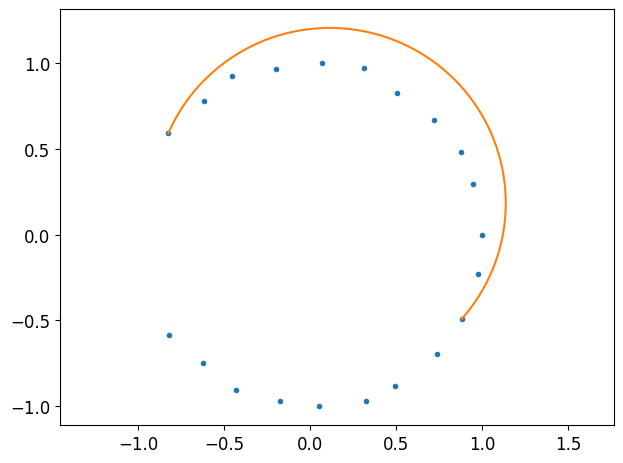

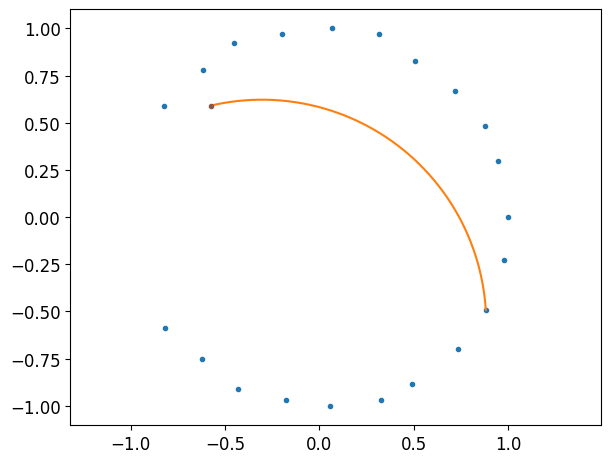

average error = 1.009770393371582 \pm 0.5123293995857239
average variation error = 0.48686978220939636 \pm 0.18934592604637146


In [18]:
# plot geodesics
plt.plot(c_data[:,0], c_data[:,1], '.')
plt.plot(c_gamma_12_t.squeeze().detach().numpy()[:,0], c_gamma_12_t.squeeze().detach().numpy()[:,1])
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"geodesics_on_c_M.eps"))
plt.show()

# plot geodesic variations
plt.plot(c_data[:,0], c_data[:,1], '.')
plt.plot(c_gamma_12_var_t.squeeze().detach().numpy()[:,0], c_gamma_12_var_t.squeeze().detach().numpy()[:,1])
plt.plot(c_z1_var[:,0], c_z1_var[:,1], '.', color=colors[5])
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"geodesic_variations_on_c_M.eps"))
plt.show()

# print errors
c_mean_error = torch.mean(error_c_gamma_12_t)
c_std_error = torch.std(error_c_gamma_12_t)
print(f"average error = {c_mean_error.squeeze().detach().numpy()} \pm {c_std_error.squeeze().detach().numpy()}")

c_mean_var_error = torch.mean(error_c_gamma_12_var_t)
c_std_var_error = torch.std(error_c_gamma_12_var_t)
print(f"average variation error = {c_mean_var_error.squeeze().detach().numpy()} \pm {c_std_var_error.squeeze().detach().numpy()}")

In [19]:
# barycentre
c_data_var = c_data + 0.05 * torch.randn((num_data, 2))

# compute barycentre
c_barycentre = c_M.barycentre(c_data[None])

# compute error
error_c_barycentre = torch.norm(c_barycentre - torch.tensor([1., 0.]), 2, -1)

# compute geodesics variation
c_barycentre_var =  c_M.barycentre(c_data_var[None], initialisation=c_barycentre)

# compute error wrt original geodesic
error_c_barycentre_var = torch.norm(c_barycentre_var - c_barycentre, 2, -1)

gradient descent was terminated after reaching a relative error 0.0007930092979222536 in 26 iterations
gradient descent was terminated after reaching a relative error 0.0006922842585481703 in 107 iterations


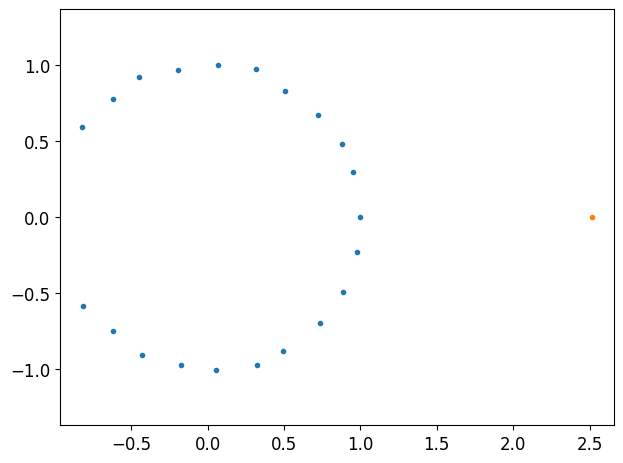

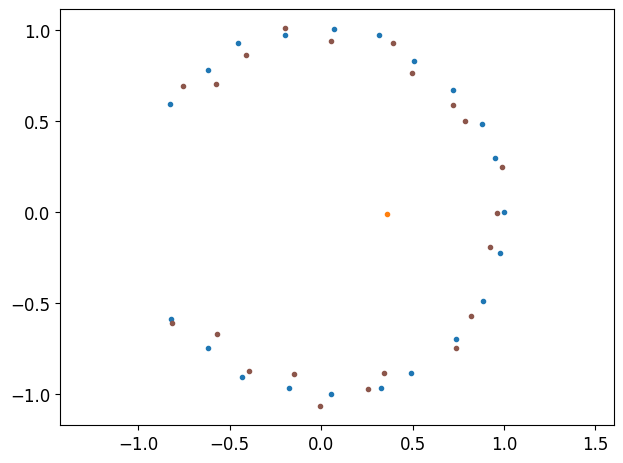

error = 1.5171563625335693
average variation error = 2.1555426120758057


In [20]:
# plot barycentre
plt.plot(c_data[:,0], c_data[:,1], '.')
plt.plot(c_barycentre[:,0].detach().numpy(), c_barycentre[:,1].detach().numpy(), '.')
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"barycentre_on_c_M.eps"))
plt.show()

plt.plot(c_data[:,0], c_data[:,1], '.')
plt.plot(c_barycentre_var[:,0].detach().numpy(), c_barycentre_var[:,1].detach().numpy(), '.')
plt.plot(c_data_var[:,0], c_data_var[:,1], '.', color=colors[5])
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"barycentre_variation_on_c_M.eps"))
plt.show()

# print errors
print(f"error = {(error_c_barycentre).squeeze().detach().numpy()}")

print(f"average variation error = {(error_c_barycentre_var).squeeze().detach().numpy()}")

In [21]:
# compute logs
c_logs = c_M.log(c_z3, c_data[None])[0]

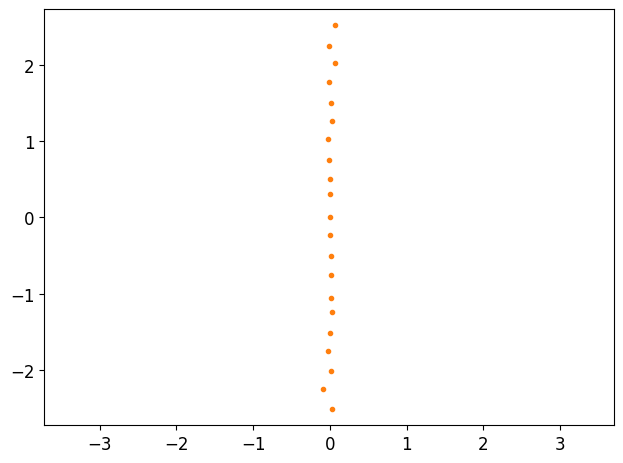

In [22]:
plt.plot(c_logs.squeeze().detach().numpy()[:,0], c_logs.squeeze().detach().numpy()[:,1], '.', color=colors[1])
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"logs_on_c_M.eps"))
plt.show()

In [23]:
# low rank approximation
# noisy_c_data = circle(250, noise=0.1)

c_z = c_z3

# construct CC-RAE from test data

# i) rank 1 approximation
c_R_z, c_U = naive_low_rank_approximation(c_M, c_z, c_data, 1)
c_w_z = c_R_z / c_M.norm(c_z, c_R_z[None])[:,None]

# ii) construct CC-RAE
c_rae_w_z = Curvature_Corrected_Riemannian_Autoencoder(c_M, c_z, c_w_z)

# project noisy validation data onto manifold with RAE
projected_c_mesh = c_rae_w_z.project_on_manifold(c_data)

# compute error
error_projected_c_mesh = torch.norm(projected_c_mesh - c_data, 2, -1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


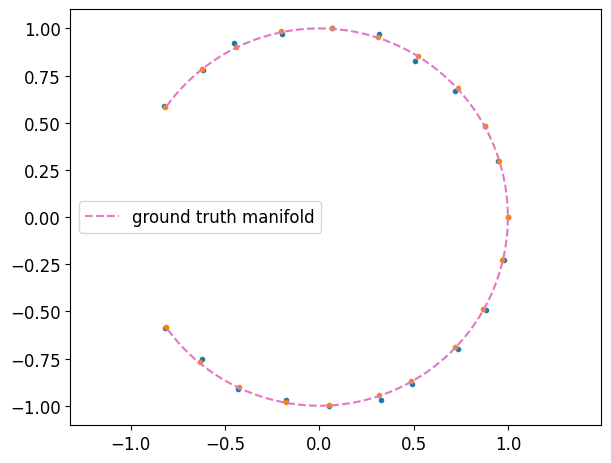

average error = 0.013729678466916084 \pm 0.00887206569314003


In [24]:
# plot rae projections
plt.plot(c_data[:,0], c_data[:,1], '.')
plt.plot(projected_c_mesh.cpu().detach().numpy()[:,0], projected_c_mesh.cpu().detach().numpy()[:,1], '.')
plt.plot(c_data_manifold[:,0], c_data_manifold[:,1], "--", label="ground truth manifold", color=colors[6])
plt.legend()
plt.axis('equal')
plt.savefig(os.path.join(results_path,f"rae_projections_on_c_M.eps"))
plt.show()

# print errors
mean_c_rae_error = torch.mean(error_projected_c_mesh)
std_c_rae_error = torch.std(error_projected_c_mesh)
print(f"average error = {mean_c_rae_error.squeeze().detach().numpy()} \pm {std_c_rae_error.squeeze().detach().numpy()}")